# 1.4 Friend recommendation in personalized networks

In [33]:
rm(list = ls());
library(igraph)

In [34]:
edge_list <- read.table("facebook_combined.txt");

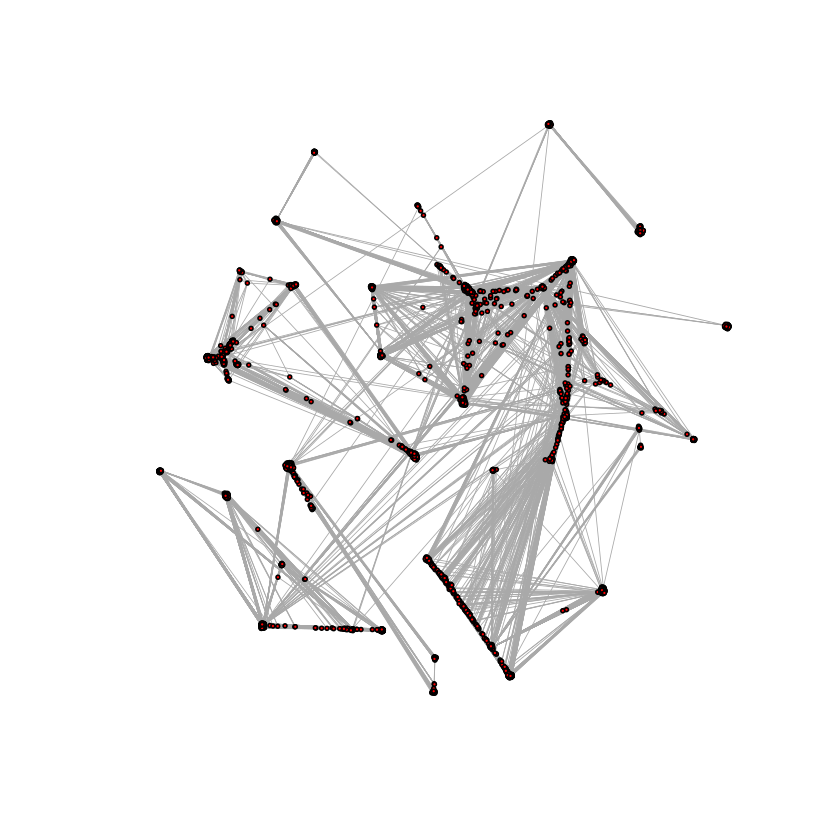

In [35]:
node_list1 <- names(table(edge_list$V1));
node_list2 <- names(table(edge_list$V2));
node_list <- union(node_list1, node_list2);
net <- graph_from_data_frame(d=edge_list, vertices=node_list, directed=FALSE) 
plot(net,vertex.size=1,vertex.label=NA, vertex.color="red",
     edge.width=0.5,edge.arrow.size=0.1);

In [36]:
d<-diameter(net, directed = FALSE, unconnected =FALSE);
print(d)

[1] 8


[1] 160

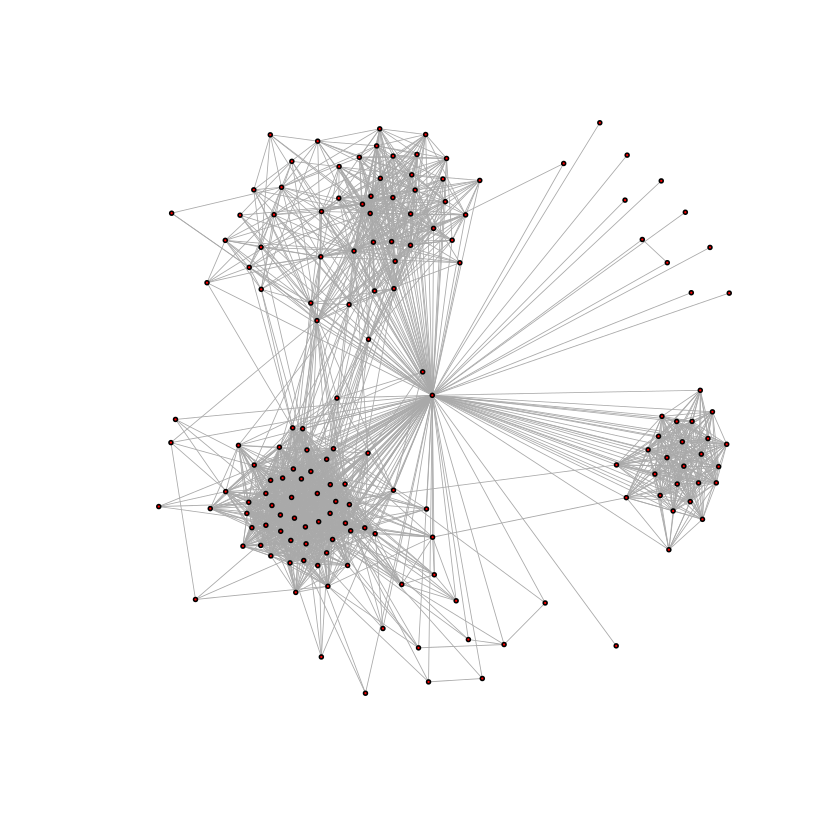

In [37]:
sub_edge_list <- edge_list[(edge_list$V1 == 414) | (edge_list$V2 == 414),];#edges containing node whose ID is 415
#sub_edge_list
sub_node_list <- union(names(table(sub_edge_list$V1)), names(table(sub_edge_list$V2)));

# gengerate induced graph
pernet_415 <- induced_subgraph(net, sub_node_list);
V(pernet_415)$localid<-seq(1:vcount(pernet_415))
vcount(pernet_415)
plot(pernet_415,vertex.size=1,vertex.label=NA, vertex.color="red",
     edge.width=0.5,edge.arrow.size=0.1);

In [38]:
V(pernet_415)$localid
V(pernet_415)$name

[1]   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
 [19]  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
 [37]  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
 [55]  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
 [73]  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
 [91]  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
[109] 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
[127] 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
[145] 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160

[1] "34"  "107" "173" "348" "363" "370" "373" "374" "376" "378" "391" "394"
 [13] "395" "400" "412" "414" "422" "423" "427" "428" "431" "434" "436" "438"
 [25] "461" "465" "475" "480" "483" "492" "496" "500" "506" "513" "514" "515"
 [37] "524" "542" "544" "553" "556" "558" "559" "561" "563" "566" "567" "573"
 [49] "574" "575" "576" "577" "578" "579" "580" "581" "582" "583" "584" "586"
 [61] "587" "588" "589" "590" "591" "592" "594" "595" "596" "597" "598" "599"
 [73] "600" "601" "603" "604" "605" "606" "609" "611" "612" "614" "615" "616"
 [85] "617" "618" "619" "620" "621" "622" "623" "625" "626" "627" "628" "629"
 [97] "630" "631" "632" "633" "634" "635" "636" "637" "639" "640" "641" "643"
[109] "644" "645" "646" "647" "649" "650" "651" "653" "654" "655" "657" "658"
[121] "659" "661" "662" "664" "665" "666" "669" "670" "672" "675" "676" "677"
[133] "678" "679" "680" "585" "593" "602" "607" "608" "610" "613" "624" "638"
[145] "642" "648" "652" "656" "660" "663" "667" "668" "671" "673" "674" "681"
[157] "682" "683" "684" "685"

## Question 16

In [39]:
sub_node_list
degreeseq <- degree(pernet_415)
#degreeseq
Nr <- as.integer(names(degreeseq[which(degreeseq==24)]))
Nr
print(paste("Number of users in Nr =",length(Nr),sep=" "));

[1] "34"  "107" "173" "348" "363" "370" "373" "374" "376" "378" "391" "394"
 [13] "395" "400" "412" "414" "422" "423" "427" "428" "431" "434" "436" "438"
 [25] "461" "465" "475" "480" "483" "492" "496" "500" "506" "513" "514" "515"
 [37] "524" "542" "544" "553" "556" "558" "559" "561" "563" "566" "567" "573"
 [49] "574" "575" "576" "577" "578" "579" "580" "581" "582" "583" "584" "585"
 [61] "586" "587" "588" "589" "590" "591" "592" "593" "594" "595" "596" "597"
 [73] "598" "599" "600" "601" "602" "603" "604" "605" "606" "607" "608" "609"
 [85] "610" "611" "612" "613" "614" "615" "616" "617" "618" "619" "620" "621"
 [97] "622" "623" "624" "625" "626" "627" "628" "629" "630" "631" "632" "633"
[109] "634" "635" "636" "637" "638" "639" "640" "641" "642" "643" "644" "645"
[121] "646" "647" "648" "649" "650" "651" "652" "653" "654" "655" "656" "657"
[133] "658" "659" "660" "661" "662" "663" "664" "665" "666" "667" "668" "669"
[145] "670" "671" "672" "673" "674" "675" "676" "677" "678" "679" "680" "681"
[157] "682" "683" "684" "685"

[1] 496 578 600 615 618 627 643 658 659 661 662

[1] "Number of users in Nr = 11"


In [40]:
Nr_list<-rep(0,length(Nr))
i<-1
for(v in V(pernet_415))
{
    if(degree(pernet_415,v)==24)
    {
        Nr_list[i]=v
        i<-i+1
    }
}
Nr_list
for(v in Nr_list){
    #print(v)
    print(V(pernet_415)[V(pernet_415)$localid==v])
}

[1]  31  53  73  83  86  94 108 120 121 122 123

+ 1/160 vertex, named, from 28bbd6a:
[1] 496
+ 1/160 vertex, named, from 28bbd6a:
[1] 578
+ 1/160 vertex, named, from 28bbd6a:
[1] 600
+ 1/160 vertex, named, from 28bbd6a:
[1] 615
+ 1/160 vertex, named, from 28bbd6a:
[1] 618
+ 1/160 vertex, named, from 28bbd6a:
[1] 627
+ 1/160 vertex, named, from 28bbd6a:
[1] 643
+ 1/160 vertex, named, from 28bbd6a:
[1] 658
+ 1/160 vertex, named, from 28bbd6a:
[1] 659
+ 1/160 vertex, named, from 28bbd6a:
[1] 661
+ 1/160 vertex, named, from 28bbd6a:
[1] 662


### Average accuracy of friends recommendation algorithm

In [59]:
CommonNeighbor<-function(network,i,j)
{
    ineighbors <- neighbors(network,i,mode = "total")
    jneighbors <- neighbors(network,j,mode = "total")
    intersection <- intersection(ineighbors,jneighbors)
    #print(intersection)
    return(length(intersection))
}

In [55]:
Jaccard<-function(network,i,j)
{
    ineighbors <- neighbors(network,i,mode = "total")
    jneighbors <- neighbors(network,j,mode = "total")
    intersec <- intersection(ineighbors,jneighbors)
    uni <-union(ineighbors,jneighbors)
    return(length(intersec)/length(uni))
}

In [56]:
Adamic_Adar<-function(network,i,j)
{
    ineighbors <- neighbors(network,i,mode = "total")
    jneighbors <- neighbors(network,j,mode = "total")
    intersect <- intersection(ineighbors,jneighbors)
    metric=0
    for(n in intersect)
    {
        nn<- neighbors(network,n,mode = "total")
        metric<- metric+1/(log(length(nn)))
    }
    return(metric)
}

In [44]:
Recommend_K_Users<-function(network,user,K,metric)
{
    user_neighbors<-neighbors(network,user,mode = "total")
    #print(user_neighbors)
    non_neighbors<-difference(V(network),user_neighbors)
    nnon<-length(non_neighbors)
    metric_value<-rep(0,nnon)
    
    if(metric=="CommonNeighbor")
    {
        for(i in seq(1:nnon))
        {
            metric_value[i]<-CommonNeighbor(network,user,non_neighbors[i])
        }
    }
    
    else if(metric=="Jaccard")
    {
        for(i in seq(1:nnon))
        {
            metric_value[i]<-Jaccard(network,user,non_neighbors[i])
        }
    }
    
    else if(metric=="Adamic_Adar")
    {
        for(i in seq(1:nnon))
        {
            metric_value[i]<-Adamic_Adar(network,user,non_neighbors[i])
        }
    }
    
    df<-data.frame(non_neighbors$localid,metric_value)
    rownames(df) <- df$non_neighbors
    df_sorted <- df[order(-metric_value),]
    # print(df_sorted)
    end<-K+1
    return(df_sorted[2:end,]$non_neighbors.localid)
}


In [45]:
l=(Recommend_K_Users(pernet_415,user=2,K=5,"CommonNeighbor"))
l
#j=(Recommend_K_Users(pernet_415,user=2,K=5,"Jaccard"))
#j
#a=(Recommend_K_Users(pernet_415,user=2,K=5,"Adamic_Adar"))
#a

[1]  7 34 10 23 30

In [46]:
Accuracy_one_user<-function(network,user,metric){
    score<-rep(0,10)
    neighbors<-neighbors(network,user,mode = "total")
    #print(neighbors)
    removed_n<-floor(length(neighbors)*0.25)
    for(i in seq(1,10))
    {
        removed_node<-sample(neighbors,size=removed_n,replace=FALSE)
        network_edge_removed<-network
        for(j in seq(1,removed_n))#note to use different loop variable other than i !
        {
            neighborid<-removed_node[j]$localid
            edgeid<-get.edge.ids(network_edge_removed, c(user,neighborid))#convert id!!need local id !
            network_edge_removed<-delete_edges(network_edge_removed,edgeid)
        }
        recommended_node<-Recommend_K_Users(network_edge_removed,user,removed_n,metric)
        print(recommended_node)
        print(removed_node$localid)
        score[i]<-length(intersection(removed_node,recommended_node))/removed_n
    }
    return(mean(score))
}

In [47]:
Accuracy_one_user(pernet_415,31,"Adamic_Adar")

[1] 30 31 43 46  5 34
[1] 107   9  34  24  19  46
[1] 30 20 43 44 14  5
[1]  24  55 104  40  36  22
[1] 29 30 34 10 14 20
[1] 29 22 34  4 10 46
[1] 20 14 30 29 43 27
[1] 29 35  8 24 55 27
[1] 30 14 43 20  5 11
[1]   8  40  36  24 127  22
[1] 30 20 10 14 29  9
[1] 10 33 29 55  9 46
[1] 30 11 43 14 65  5
[1] 40 65 23 22 36 24
[1] 31 11 43 14 32 46
[1] 22 19 46 23 33 36
[1] 29 30 31 43 20  5
[1] 24 29  8 19 22 55
[1] 30 20 14 29 43 27
[1]  29 104  46  33  35  27


[1] 0.25

In [48]:
len<-length(Nr_list)
cn_score<-rep(0,len)
jaccard_score<-rep(0,len)
adamicadar_score<-rep(0,len)
for(i in seq(1,len))
{
    cn_score[i]<-Accuracy_one_user(pernet_415,Nr_list[i],"CommonNeighbor")
    jaccard_score[i]<-Accuracy_one_user(pernet_415,Nr_list[i],"Jaccard")
    adamicadar_score[i]<-Accuracy_one_user(pernet_415,Nr_list[i],"Adamic_Adar")
}

[1] 31 30 43 14 27  4
[1]   4  36 127  16  27  33
[1] 14 30 43 11 23 29
[1]   8  23 127  35 107  29
[1] 11 30 43  5 32 44
[1]  36  24 107  23  27  22
[1] 31 30 65 43  4 14
[1]  16  65 127   4  27  35
[1] 30 10 14 29 34 43
[1] 104  34  10  36  27  29
[1] 31 34 11 43  5  6
[1]  22  23  34  65 104  19
[1] 30 43 14 27 36 65
[1]  36 127  27  33  65  24
[1] 31 10 43 65 14 37
[1]  10  55  35 127  19  65
[1]  7 30 43 14 33 36
[1]  55  33  35  36   7 127
[1] 30 43 11 14 23 36
[1] 36 23 24 40 35 55
[1] 36 11 30 10  5 32
[1] 33 16 23 27 10 36
[1]  5 30 21 14 11 27
[1]  34 104  65 127   8  27
[1]  5 46 11 30 21 43
[1]  19  10 107  55   4  46
[1] 11 30 46  5 36 32
[1] 46 27 19 36  7 23
[1] 21 11  5 45 30  6
[1]  40 107  55 104  23   9
[1]  5 11 30 22 21 14
[1]  7 19 65 40 22  8
[1]  5 11 30 43 21 14
[1]  33  40 107  34  29  23
[1] 11 45 30 21  5 36
[1] 36 23 16 40 65 15
[1]  5 36 11 30 14 32
[1] 55 24 29 23 27 36
[1] 45 78 35 30 21 26
[1]  40  35  36  10 104  15
[1] 31  7 30 43 14 20
[1]  16 107   

In [49]:
print(paste("Common Neighbors Measure:",mean(cn_score)))

[1] "Common Neighbors Measure: 0.733333333333333"


In [50]:
print(paste("Jaccard Measure:",mean(jaccard_score)))

[1] "Jaccard Measure: 0.804545454545455"


In [51]:
print(paste("Adamic_Adar Measure:",mean(adamicadar_score)))

[1] "Adamic_Adar Measure: 0.737878787878788"


In [52]:
len<-length(Nr_list)
cn_score<-rep(0,len)
jaccard_score<-rep(0,len)
adamicadar_score<-rep(0,len)
for(i in seq(1,len))
{
    cn_score[i]<-Accuracy_one_user(pernet_415,Nr_list[i],"CommonNeighbor")
    jaccard_score[i]<-Accuracy_one_user(pernet_415,Nr_list[i],"Jaccard")
    adamicadar_score[i]<-Accuracy_one_user(pernet_415,Nr_list[i],"Adamic_Adar")
}
print(paste("Common Neighbors Measure:",mean(cn_score)))
print(paste("Jaccard Measure:",mean(jaccard_score)))
print(paste("Adamic_Adar Measure:",mean(adamicadar_score)))

[1] 30 31 10 14 34 43
[1] 10  8 27 34 16 19
[1] 31 43 11 14 46  5
[1] 40 15  4 23 19 46
[1] 30 31 43 11 14 21
[1]  55   9  33  65  19 107
[1] 31  7 30 10 43 11
[1]  4 10  7 22 35 16
[1] 30 14 29 34 43 20
[1] 29 55 34 40 27 15
[1] 31 30 10 43 14 44
[1]  16  35  10 104  40  36
[1] 30 31 34 14 43  5
[1] 22 16 33  8 34 19
[1] 30 31 43 11 14 37
[1] 107   9  33  19  23  55
[1]  7 30 11 43 14 37
[1] 35  7 22 55 23 27
[1] 31 43 14 11 33 37
[1] 104  19  33 127   8 107
[1] 30 10  5 11 45 43
[1] 35 15 10 55  7  9
[1]   5  11 107  45  30  43
[1]  15  24  35  40 107   4
[1]  5 30 46 14 11 43
[1] 24 15 16 46  9 29
[1]  5 10 11 30 22 14
[1]  7 24 22 10 29  9
[1]  5 36 11 30 32  2
[1] 24 36 35 34 23  7
[1] 11 30  8 55 14  5
[1] 55 35  8 23 33  9
[1]  5 11 30 22 10 36
[1] 36 35 22 34 10  7
[1] 11 30  5 43 21 14
[1] 23 35 27 19  9 40
[1]  5 11 30 14 29 32
[1]  9 16 36 27 22 29
[1]  5 11 30 43 21 65
[1] 107  33  34  24  65   4
[1] 14 29 30 20 43 11
[1] 29 22 46 35  8 40
[1] 30 34 10 43 14 27
[1] 22 34 10

[1] "Common Neighbors Measure: 0.728787878787879"
[1] "Jaccard Measure: 0.815151515151515"
[1] "Adamic_Adar Measure: 0.736363636363636"


In [60]:
len<-length(Nr_list)
cn_score<-rep(0,len)
jaccard_score<-rep(0,len)
adamicadar_score<-rep(0,len)
for(i in seq(1,len))
{
    cn_score[i]<-Accuracy_one_user(pernet_415,Nr_list[i],"CommonNeighbor")
    jaccard_score[i]<-Accuracy_one_user(pernet_415,Nr_list[i],"Jaccard")
    adamicadar_score[i]<-Accuracy_one_user(pernet_415,Nr_list[i],"Adamic_Adar")
}
print(paste("Common Neighbors Measure:",mean(cn_score)))
print(paste("Jaccard Measure:",mean(jaccard_score)))
print(paste("Adamic_Adar Measure:",mean(adamicadar_score)))

[1] 30  9 34 43 65  4
[1]  40 104   9  65   4  34
[1] 30 31 14 43 11 23
[1] 36 23 16 19  4  8
[1] 30  9 43 11 14 65
[1]  23  33 104  65   9  24
[1] 30 10 34 43 14  5
[1] 127  33  15  35  10  34
[1] 31 30  9 37 43 11
[1]  22  55 127   9  16  40
[1] 31 14 43 11 23 46
[1] 23  8 46 19 36 65
[1] 31  9 43 14 46  5
[1] 19  9 24 35 33 46
[1]  9 30 43 34  5 11
[1]   9  34  36   4  33 107
[1] 30 27 43 46 14 20
[1] 127  55  46  27  33  15
[1] 30 43  5 11 14 32
[1]  15 107 127  24  33  36
[1] 30 10  5 11 45 65
[1] 16 35 33 65 15 10
[1] 30 55 10 14  5 11
[1]  10  35 127  55   7   8
[1]  5 22 10 14 11 30
[1] 65 29 10 22  8 24
[1] 30 46 10 14  5 11
[1]  4 16 29  7 46 10
[1] 30 46  5 11 43 55
[1]  4  7 55 19 46 27
[1]  5 11 30  6 43 22
[1]  34  22 107   4   9  27
[1] 22  5 11 35 45 30
[1] 29 35 65 36 40 22
[1]  5 46 36 30 11 32
[1]  36 127  34  46  27  24
[1] 11 30 21 10  5 32
[1]  40  33  10 127 104  23
[1]  5 30 21 14 11 65
[1] 24 65  7 40  8  4
[1] 30 31  9 43 14 65
[1] 19  9 55 15 16 65
[1]  7 30 

[1] "Common Neighbors Measure: 0.739393939393939"
[1] "Jaccard Measure: 0.815151515151515"
[1] "Adamic_Adar Measure: 0.748484848484849"
